<div style="color: pink; padding: 10px; font-size: 75px;">
TITLE
</div>

In [133]:
import numpy as np
import gzip
import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [108]:
dataset = []

max_lines = 1000000
dataset = []
with gzip.open("Electronics.jsonl.gz", "rt", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= max_lines:
            break
        dataset.append(json.loads(line))

In [109]:
dataset[0]

{'rating': 3.0,
 'title': 'Smells like gasoline! Going back!',
 'text': 'First & most offensive: they reek of gasoline so if you are sensitive/allergic to petroleum products like I am you will want to pass on these.  Second: the phone adapter is useless as-is. Mine was not drilled far enough to be able to tighten it into place for my iPhone 12 max. It just slipped & slid all over. Stupid me putting the adapter together first without picking up the binoculars to smell them bc I wasted 15 minutes trying to figure out how to put the adapter together bc it does not come with instructions!  I had to come back here to the website which was a total pain. Third: the tripod is also useless. I would not trust the iOS to hold my $1600 phone nor even a Mattel Barbie for that matter. It’s just inefficient for the job imo.  Third: in order to try to give an honest review I did don gloves & eyewear to check the binoculars out.  They seemed average except for mine seemed to be missing about 10% of the

<div style="color: pink; padding: 10px; font-size: 50px;">
Baseline Rating Prediction Model
</div>

In [ ]:
allRatings = []
userRatings = defaultdict(list)

for d in dataset:
    user, item, rating = d['user_id'], d['asin'], d['rating']
    allRatings.append((user,item,rating))
    userRatings[user].append(rating)

print(allRatings[0])


('AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'B083NRGZMM', 3.0)


In [ ]:
ratings = [rating for _,_,rating in allRatings]
for rating in ratings:
    if rating not in {0, 1, 2, 3, 4, 5}:  # Check if the rating is not 0-5
        print(f"The first invalid rating is: {rating}")
        break
else:
    print("All ratings are valid (0-5).")

All ratings are valid (0-5).


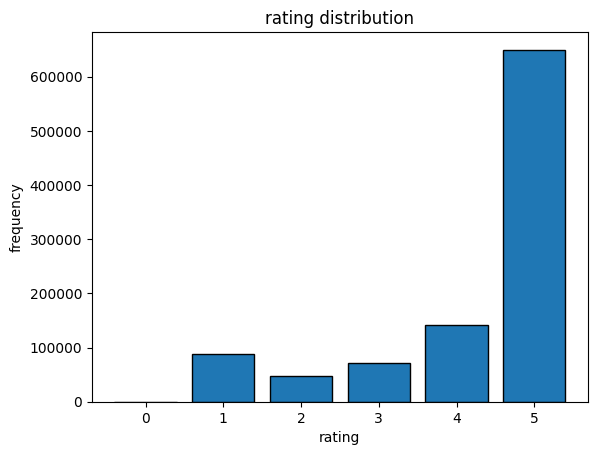

In [145]:
plt.hist([rating for _,_,rating in allRatings], bins=[0, 1, 2, 3, 4, 5, 6], edgecolor='black', align='left', rwidth=0.8)
plt.title("rating distribution")
plt.xlabel("rating")
plt.ylabel("frequency")
plt.show()

In [111]:
globalAverage = sum([rating for _,_,rating in allRatings]) / len(allRatings)
print("global average rating", globalAverage)

global average rating 4.215798


<div style="color: lightblue; padding: 10px; font-size: 30px;">
Data Cleaning/Creation
</div>

In [112]:
train_test_split_fraction = 0.80
valid_test_split_fraction = 0.50

N = int(len(allRatings)*train_test_split_fraction)
ratingsTrain = allRatings[:N]
temp = allRatings[N:]

N = int(len(temp)*valid_test_split_fraction)
ratingsValid = temp[:N]
ratingsTest = temp[N:]
print(len(ratingsTrain),len(ratingsValid),len(ratingsTest))

800000 100000 100000


In [148]:
#maybe rebalance the ratings distribtion here

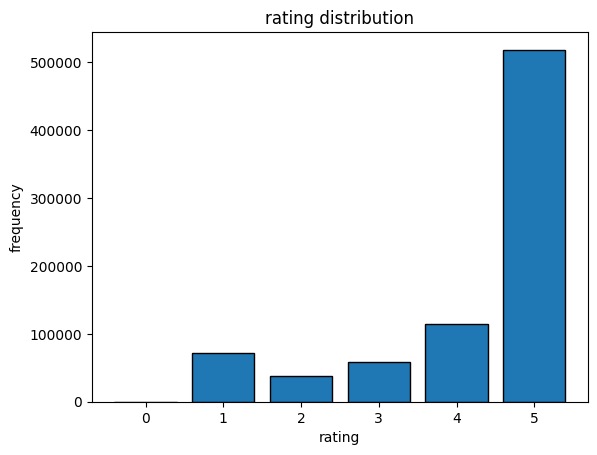

In [147]:
#delete this later just to check the distribution of the ratings in Train set
plt.hist([rating for _,_,rating in ratingsTrain], bins=[0, 1, 2, 3, 4, 5, 6], edgecolor='black', align='left', rwidth=0.8)
plt.title("rating distribution")
plt.xlabel("rating")
plt.ylabel("frequency")
plt.show()

In [113]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
userRatings = {}
for user,item,rating in ratingsTrain:
    usersPerItem[item].add((user,rating))
    itemsPerUser[user].add((item,rating))
    userRatings[(user,item)] = rating

print("number of items", len(usersPerItem))
print("number of users", len(itemsPerUser))    


number of items 277965
number of users 146645


<div style="color: lightblue; padding: 10px; font-size: 30px;">
MODEL
</div>

In [114]:
def train_rating_predictor(iterations, ratingsTrain, alpha, regularizer):
    beta_user = defaultdict(float)
    beta_item = defaultdict(float)
    N = len(ratingsTrain)
 
    for i in range(iterations):
        num = sum(rating - (beta_user[user] + beta_item[item]) for user, item, rating in ratingsTrain)
        alpha = num / N
        
        for user in itemsPerUser:
            num =0
            for item,rating in itemsPerUser[user]:
                num += rating - (alpha + beta_item[item])
            beta_user[user] = num/(regularizer+len(itemsPerUser[user]))

        
        for item in usersPerItem:
            num =0
            for user,rating in usersPerItem[item]:
                num += rating - (alpha + beta_user[user])
            beta_item[item] = num/(regularizer+len(usersPerItem[item]))



    return alpha, beta_user, beta_item


def rating_predictor(user,item,alpha,beta_user,beta_item):
    return alpha + beta_user[user] + beta_item[item]


def predict(dataset,alpha,beta_user,beta_item):
    pred = []
    for user,item,rating in dataset:
        pred.append(alpha + beta_user[user] + beta_item[item])
    return pred

def predictAndMSE(dataset, alpha, beta_user, beta_item):
    error =0
    for user,item,rating in dataset:
        prediction = alpha + beta_item[item] + beta_user[user]
        error += (prediction-rating)**2

    return error/len(dataset)

def MSE(predictions, true):
    error =0
    for i,rating in enumerate(true):
        error += (predictions[i]-rating)**2

    return error/len(true)


In [115]:
alpha, beta_user, beta_item = train_rating_predictor(10, ratingsTrain, globalAverage,1)

In [116]:
pred = predict(ratingsValid, alpha, beta_user, beta_item)

In [117]:
# validMSE = predictAndMSE(ratingsValid, alpha, beta_user, beta_item)
# print("MSE:",validMSE)

mse = MSE(pred, [rating for _,_,rating in ratingsValid]) 
print("MSE:",mse)

MSE: 1.6890444186295066


<div style="color: lightblue; padding: 10px; font-size: 30px;">
Hyper parameter tuning
</div>

In [118]:

lamb_vals = [1,2,5,10,15,20]
best_lamb = lamb_vals[0]
validMSE = float("inf")
for val in lamb_vals:
    alpha, beta_user, beta_book = train_rating_predictor(5, ratingsTrain, globalAverage, val)
    tempMSE = predictAndMSE(ratingsValid, alpha, beta_user, beta_book)
    print(val, tempMSE)
    if tempMSE < validMSE:
        validMSE = tempMSE
        lamb = val

print(f"best lambda value is {best_lamb} with MSE {validMSE}")

1 1.6885303660478013
2 1.6568655117504456
5 1.6361039145978538
10 1.6330469305530304
15 1.6345694788625122
20 1.6366384416015025
best lambda value is 1 with MSE 1.6330469305530304


In [130]:
#show graph here with varying lambdas

<div style="color: lightblue; padding: 10px; font-size: 30px;">
Baseline prediction metrics
</div>

In [ ]:
alpha, beta_user, beta_book = train_rating_predictor(10, ratingsTrain, globalAverage, best_lamb)

In [125]:
pred = predict(ratingsTest, alpha, beta_user, beta_item)

In [131]:
baseline_mse = MSE(pred, [rating for _,_,rating in ratingsTest]) 
print("MSE:",mse)

MSE: 1.6568548084681705


<div style="color: pink; padding: 10px; font-size: 50px;">
Latent Factor Model
</div>

In [ ]:
class PredictionModel():
    def __init__(self,iterations, alpha=0, learning_rate = 0.1, regularizer=0, num_factors = 10):
        self.iterations = iterations
        self.alpha = alpha
        self.regularizer = regularizer
        self.learning_rate = learning_rate
        self.beta_user = defaultdict(float)
        self.beta_item = defaultdict(float)
        self.factor_user = defaultdict(lambda: np.random.normal(scale=0.1, size=num_factors)) #np.random.normal(scale=0.1, size=(n_users, factors))
        self.factor_item = defaultdict(lambda: np.random.normal(scale=0.1, size=num_factors)) #np.random.normal(scale=0.1, size=(n_items, factors))


    def train_model(ratingsTrain):
        return
    
    def predict(dataset):
        return

    def MSE(pred,real):

        
        return

In [129]:
allRatings = []
userRatings = defaultdict(list)

for d in dataset:
    user, item, rating = d['user_id'], d['asin'], d['rating']
    allRatings.append((user,item,rating))
    userRatings[user].append(rating)

print(allRatings[0])

('AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'B083NRGZMM', 3.0)


In [ ]:
globalAverage = sum([rating for _,_,rating in allRatings]) / len(allRatings)
print("global average rating", globalAverage)

In [135]:
latentModel = PredictionModel(globalAverage, 0.1, 1, 10)